# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [2]:
# Load the texts from Project Gutenberg
import requests

# URLs of the texts
urls = [
    'https://www.gutenberg.org/cache/epub/31547/pg31547.txt',  # Youth
    'https://www.gutenberg.org/cache/epub/68377/pg68377.txt'   # Let's Get Together
]

# Initialize an empty string to hold the combined text
dataset = ''

# Fetch and combine the texts
for url in urls:
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful
    dataset += response.text

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
fraction = 1.0  # Adjust this value as needed
dataset_small = dataset[:int(len(dataset) * fraction)]

# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
# Display the first 1,000 characters
print(dataset[:1000])

# Calculate the total number of characters
total_characters = len(dataset)
print(f'Total number of characters: {total_characters}')

# Identify unique characters
unique_characters = set(dataset)
num_unique_characters = len(unique_characters)
print(f'Number of unique characters: {num_unique_characters}')

﻿The Project Gutenberg eBook of Youth
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Youth

Author: Isaac Asimov

Release date: March 7, 2010 [eBook #31547]
                Most recently updated: January 6, 2021

Language: English

Credits: Produced by Greg Weeks, Stephen Blundell and the Online
        Distributed Proofreading Team at https://www.pgdp.net


*** START OF THE PROJECT GUTENBERG EBOOK YOUTH ***




Produced by Greg Weeks, Stephen Blundell and the Online
Distributed Proofreading Team at https://www.pgdp.net









YOUTH

_by_ ISA
Total number of characters: 133701
Numbe

## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the OOV token explicitly as later code needs this.
OOV_TOKEN = "<OOV>"
VOCAB_SIZE = 10000  # Set this globally to align with the pre-written code

# Step 1: Clean Headers, Footers, and Carriage Returns
start_index = dataset.find("*** START OF THE PROJECT GUTENBERG EBOOK")
end_index = dataset.find("*** END OF THE PROJECT GUTENBERG EBOOK")
if start_index != -1 and end_index != -1:
    dataset_clean = dataset[start_index:end_index]
else:
    dataset_clean = dataset  # Fallback in case metadata markers aren't present

# Remove carriage returns
dataset_clean = dataset_clean.replace('\r', '')

# Step 2: Convert to Lowercase
dataset_clean = dataset_clean.lower()

# Step 3: Tokenize Text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([dataset_clean])

# Step 4: Convert the text into sequences
sequences = tokenizer.texts_to_sequences([dataset_clean])

# Print the vocabulary size and top 10 words
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")
print(f"Top 10 words: {list(word_index.items())[:10]}")

Vocabulary size: 1947
Top 10 words: [('<OOV>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('i', 6), ('you', 7), ('it', 8), ('a', 9), ('he', 10)]


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [5]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)


[('<OOV>', 1), ('the', 2), ('to', 3), ('and', 4), ('of', 5), ('i', 6), ('you', 7), ('it', 8), ('a', 9), ('he', 10)]



## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [6]:
SEQ_LENGTH = 50 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
# sequences = None
# Since the dataset has already been tokenized, flatten it
tokens = [token for sublist in sequences for token in sublist]

# Generate the training sequences
X = []
y = []

# Your code here
for i in range(0, len(tokens) - SEQ_LENGTH):
    X.append(tokens[i:i + SEQ_LENGTH])  # SEQ_LENGTH tokens as input
    y.append(tokens[i + SEQ_LENGTH])  # The next token as the target

# Convert X and y to arrays
import numpy as np
X = np.array(X)
y = np.array(y)

# Display some examples
print(f"Number of sequences: {len(X)}")
print(f"First input sequence: {X[0]}")
print(f"First target: {y[0]}")

Number of sequences: 10125
First input sequence: [279   5   2 550 847 848 135 551 136 849 850 851 852   4   2 853 854 855
 856  24 857 858 859 860 135 136 861 862  16   4  21 147   2 163 221 112
  52   2 323 137  12 192   2 280 863  12 403  14  12  95]
First target: 148


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [7]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [279   5   2 550 847 848 135 551 136 849 850 851 852   4   2 853 854 855
 856  24 857 858 859 860 135 136 861 862  16   4  21 147   2 163 221 112
  52   2 323 137  12 192   2 280 863  12 403  14  12  95]
Target: 148
Translated back to words: ['start', 'of', 'the', 'project', 'gutenberg', 'ebook', 'youth', 'produced', 'by', 'greg', 'weeks', 'stephen', 'blundell', 'and', 'the', 'online', 'distributed', 'proofreading', 'team', 'at', 'https', 'www', 'pgdp', 'net', 'youth', 'by', 'isaac', 'asimov', 'red', 'and', 'slim', 'found', 'the', 'two', 'strange', 'little', 'animals', 'the', 'morning', 'after', 'they', 'heard', 'the', 'thunder', 'sounds', 'they', 'knew', 'that', 'they', 'could'] -> never


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [8]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (8100, 50)
y_train shape: (8100, 10000)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

model = Sequential([
    # Embedding layer: input_dim = VOCAB_SIZE, output_dim = 128 (you can adjust the size)
    Embedding(input_dim=VOCAB_SIZE, output_dim=128, input_length=SEQ_LENGTH),

    # Recurrent layer: LSTM with 128 units
    LSTM(128, return_sequences=False),  # return_sequences=False since it's followed by a dense layer

    # Dense layer with softmax activation for output
    Dense(VOCAB_SIZE, activation='softmax')
])

# Build the model by specifying input shape
model.build(input_shape=(None, SEQ_LENGTH))

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 128)             │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10000)               │       1,290,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,701,584 (10.31 MB)

 Trainable params: 2,701,584 (10.31 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_
For loss function we will use categorical_crossentropy. works with the softmax activation and is ideal for multi-class classification tasks like predicting the next word in the sequence.

In [10]:
from keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with default settings
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # To track prediction accuracy
)

# Print a summary to confirm compilation
print("Model compiled successfully.")

Model compiled successfully.


## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [11]:
# Train the model
history = model.fit(
    X_train, y_train,  # Training data
    epochs=5,          # Number of epochs
    batch_size=128,    # Batch size
    validation_data=(X_val, y_val)  # Validation data
)

# Print confirmation
print("Model training completed.")

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0389 - loss: 8.4215 - val_accuracy: 0.0538 - val_loss: 6.8154
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.0554 - loss: 6.3011 - val_accuracy: 0.0538 - val_loss: 6.7314
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0506 - loss: 6.1607 - val_accuracy: 0.0538 - val_loss: 6.7019
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0539 - loss: 6.0373 - val_accuracy: 0.0538 - val_loss: 6.7114
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0508 - loss: 6.0326 - val_accuracy: 0.0538 - val_loss: 6.7533
Model training completed.


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

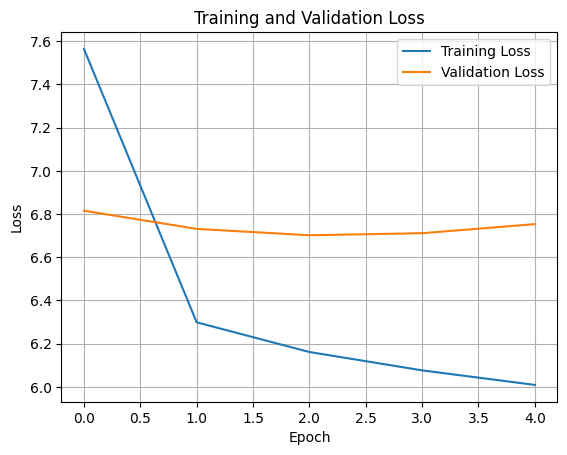

In [12]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [13]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())
    return yhat

    # Get the index of the predicted word using np.argmax
    predicted_token = np.argmax(yhat, axis=-1)[0]  # Extract the token index from the prediction
    return predicted_token

def generate_text(model, tokenizer, seed_text, max_sequence_len):

    # Initialize the result with the seed text
    result = seed_text

    # Generate tokens iteratively
    for _ in range(max_sequence_len):
        # Tokenize the seed text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # Pad the token list to match the max sequence length
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')

        # Predict the next token using the model
        predicted_token = get_predicted_word(model, token_list)

        # Convert the predicted token ID to a word
        predicted_word = tokenizer.index_word.get(predicted_token, '')

        # Break the loop if no valid prediction
        if not predicted_word:
            break

        # Append the predicted word to the result
        result += ' ' + predicted_word

        # Update the seed text to include the new word
        seed_text += ' ' + predicted_word

    return result


In [14]:
# Test the text generation function
generate_text(model, tokenizer, 'youth', SEQ_LENGTH)

'youth and sense of at he she speak of than them wash he beforethewars from odor that about a'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [15]:
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# !unzip glove.6B.zip
import os

# Check if Glove file exists
if not os.path.exists("glove.6B.100d.txt"):
    print("GloVe file not found. Downloading...")
    !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
    print("Unzipping GloVe file...")
    !unzip glove.6B.zip
else:
    print("Glove file already exists. Skipping download.")


Glove file already exists. Skipping download.


In [16]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [17]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [18]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

In [33]:
# Define a new model and train it
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Ensure labels are integer-encoded, not one-hot to try sparse categorical crossentropy
y_train = np.argmax(y_train, axis=-1) if len(y_train.shape) > 1 else y_train
y_val = np.argmax(y_val, axis=-1) if len(y_val.shape) > 1 else y_val
# implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# adding learning rate scheduler to refine later epochs
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5)

def get_predicted_word(model, sequence, temperature=0.7):
    """
    Get the predicted word using temperature sampling.
    """
    # Use the model to predict probabilities
    yhat = model.predict(sequence, verbose=0)

    # Apply temperature to logits
    yhat = np.log(yhat + 1e-7) / temperature  # Add small constant to prevent log(0)
    yhat = np.exp(yhat) / np.sum(np.exp(yhat))  # Re-normalize probabilities

    # Sample from the adjusted probability distribution
    predicted_token = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return predicted_token

# Set the embedding layer to trainable
embedding_layer.trainable = True

# Define the new model with pre-trained embeddings
improved_model = Sequential([
    # Pre-trained embedding layer
    embedding_layer,  # Already defined using pre-trained Glove embeddings

    # Add an LSTM layer
    Bidirectional(LSTM(256, return_sequences=True)),  # trying different units

    # Add a second Bidirectional LSTM layer
    Bidirectional(LSTM(128, return_sequences=False)),  # Second layer processes the output of the first

    # Add Dropout to prevent overfitting
    Dropout(0.5),

    # Dense layer with softmax activation for output
    Dense(VOCAB_SIZE, activation='softmax', kernel_regularizer=l2(0.01))
])

# Compile the model
improved_model.compile(
    optimizer='adam',  # Using Adam optimizer
    loss='sparse_categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy']
)

# Print the model summary
improved_model.summary()

# Train the improved model
history_improved = improved_model.fit(
    X_train, y_train,  # Training data
    epochs=30,         # Train for more epochs to leverage pre-trained embeddings
    batch_size=16,    # batch size
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[early_stopping, lr_scheduler]
)

# Print completion message
print("Training of the improved model completed.")


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 50, 100)             │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.0383 - loss: 8.1897 - val_accuracy: 0.0538 - val_loss: 7.2140 - learning_rate: 0.0010
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.0403 - loss: 6.9916 - val_accuracy: 0.0509 - val_loss: 7.0641 - learning_rate: 0.0010
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.0604 - loss: 6.7178 - val_accuracy: 0.0726 - val_loss: 6.9546 - learning_rate: 0.0010
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.0916 - loss: 6.4222 - val_accuracy: 0.0731 - val_loss: 6.9431 - learning_rate: 0.0010
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.1210 - loss: 6.2078 - val_accuracy: 0.0815 - val_loss: 6.9295 - learning_rate: 0.0010
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.1454 - loss: 6.0250 - val_accuracy: 0.0746 - val_loss: 6.9511 - learning_rate: 0.0010
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.1590 - l

In [34]:
seed_text = "The future of"
generated_text = generate_text(improved_model, tokenizer, seed_text, max_sequence_len=50)
print("Generated Text with Temperature Sampling:")
print(generated_text)

Generated Text with Temperature Sampling:
The future of the exploring was his penalty world slim if it was talk to the leaves and such up red when slim took the she's the from even merchant proud of my want to its entrance found them like to waved and we said he is not have to go in silence


What changed as the model was experimented on and improved:

Recurrent Layers:
Single LSTM (128 units) → Bidirectional LSTM (256 units) → Stacked Bidirectional LSTMs (2 layers)
Added bidirectional layers for better context. Improved training accuracy (~0.31) but only marginal impact on validation accuracy.

Regularization:
None → Dropout (0.2) → Dropout (0.5) + L2 Regularization
Reduced overfitting with dropout and weight penalties. Validation loss stabilized around 6.88.

Optimization:
Adam → Adam + Learning Rate Scheduler + Early Stopping
Enhanced training efficiency and prevented overfitting. Enabled better loss convergence without overtraining.

Batch Size:
128 → 16
Smaller batches improved gradient updates but increased training time. Validation accuracy peaked at ~0.08.

Epochs:
5 → 30 (with early stopping)
Longer training with controlled stopping allowed fine-tuned model convergence.

Outcome
Training accuracy reached ~0.31, validation accuracy ~0.08.
Generated text became slightly more diverse but lacked contextual depth, highlighting dataset and model limitations.

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.